In [2]:
import pandas as pd
df = pd.read_csv("../data/collaboration/country_edges.csv")

In [3]:
df.head(5)

,year,country_1,country_2,weight
0,4,China,France,1
1,208,Iran,Turkey,1
2,208,India,Turkey,1
3,208,China,India,1
4,208,Hungary,India,1


In [4]:
df_il = df[(df['country_1'] == 'Israel') | (df['country_2'] == 'Israel')]

In [6]:
def extract_non_israel_countries(df_il):
    """
    Extracts pairs where Israel is either country_1 or country_2
    and returns a DataFrame with 'country' and 'value' columns.
    """
    # Filter rows where Israel appears in either country_1 or country_2
    mask = (df_il['country_1'] == 'Israel') | (df_il['country_2'] == 'Israel')
    df_il = df_il[mask].copy()

    # Create 'country' column as the country that is not Israel
    df_il['country'] = df_il.apply(
        lambda row: row['country_2'] if row['country_1'] == 'Israel' else row['country_1'],
        axis=1
    )

    # Rename 'weight' to 'value' and keep only the needed columns
    result = df_il[['country', 'weight', 'year']].rename(columns={'weight': 'value'})

    return result

# Example usage
df_result = extract_non_israel_countries(df_il)
print(df_result.head())


            country  value  year
538   United States      1  1876
802         Ireland      1  1889
1892  United States      1  1916
2048  United States      3  1920
2175  United States      4  1922


In [8]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, PowerNorm
from matplotlib import cm

url = "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
world1 = gpd.read_file(url)

In [14]:
def plot_world_choropleth(
    df: pd.DataFrame,
    country_col: str = "country",
    value_col: str = "value",
    cmap_name: str = "viridis",
    title: str = "World choropleth",
    missing_color: str = "#f0f0f0",
    figsize=(14, 7),
    value_format: str = "{:.2f}",
    country_alias: dict | None = None,
    scale: str = "linear",
    gamma: float = 0.5,
    clip_percentiles: tuple | None = (1, 99),
    drop_missing_territories: bool = True,
    title_fontsize: int = 22,
    cbar_labelsize: int = 14,
    tick_labelsize: int = 12,
    legend_fontsize: int = 12,
    ax=None,                      # <--- new
    add_colorbar=True             # <--- new
):
    # World layer you already loaded outside
    world = world1.copy()

    # Names available in layer
    world_names = set(world["name"].astype(str).str.strip())

    # Helper to pick the first candidate that exists in the layer
    def pick_name(candidates):
        for c in candidates:
            if c in world_names:
                return c
        return None

    # Base aliases
    builtin_alias = {
        "USA": "United States of America",
        "United States": "United States of America",
        "UK": "United Kingdom",
        "Syria": "Syrian Arab Republic",
        "Vietnam": "Viet Nam",
        "South Korea": "Republic of Korea",
        "North Korea": "Dem. Rep. Korea",
        "Ivory Coast": "Côte d'Ivoire",
        "Czechia": "Czech Republic",
        "Eswatini": "eSwatini",
        "Swaziland": "eSwatini",
        "Cape Verde": "Cabo Verde",
        "Macedonia": "North Macedonia",
        "Republic of the Congo": "Congo",
        "Democratic Republic of the Congo": "Democratic Republic of the Congo",
        "Laos": "Lao PDR",
        "Brunei": "Brunei",
        "Bahamas": "Bahamas",
        "Gambia": "Gambia",
        "Venezuela": "Venezuela",
        "Bolivia": "Bolivia",
        "Tanzania": "Tanzania",
    }

    # Specific fixes from your unmatched list
    alias_fix = {
        "United States": pick_name(["United States of America", "United States"]),
        "Bahamas": pick_name(["The Bahamas", "Bahamas", "Bahamas, The"]),
        "Tanzania": pick_name(["United Republic of Tanzania", "Tanzania"]),
        "DR Congo": pick_name([
            "Democratic Republic of the Congo",
            "Congo, Dem. Rep.",
            "Congo (Kinshasa)"
        ]),
        "Eswatini": pick_name(["Eswatini", "eSwatini", "Swaziland"]),
        "Serbia": pick_name(["Serbia", "Republic of Serbia"]),
        "St Kitts and Nevis": pick_name([
            "Saint Kitts and Nevis", "St Kitts and Nevis", "St. Kitts and Nevis"
        ]),
        "Reunion": pick_name(["Réunion", "Reunion"]),
        "Guadeloupe": pick_name(["Guadeloupe"]),
        "Martinique": pick_name(["Martinique"]),
        "Hong Kong": pick_name(["Hong Kong SAR China", "Hong Kong S.A.R.", "Hong Kong"]),
        "Macao": pick_name(["Macao SAR China", "Macao S.A.R.", "Macau", "Macao"]),
        "Palestinian Territory": pick_name(["Palestine", "Palestine, State of", "Palestinian Territory"]),
    }
    alias_fix = {k: v for k, v in alias_fix.items() if v is not None}

    alias = builtin_alias.copy()
    alias.update(alias_fix)
    if country_alias:
        alias.update(country_alias)

    # Prepare data
    data = df.copy()
    data[country_col] = data[country_col].astype(str).str.strip().replace(alias)

    # Optionally drop names not present in the layer
    if drop_missing_territories:
        missing_now = sorted(set(data[country_col]) - world_names)
        if missing_now:
            data = data[~data[country_col].isin(missing_now)]

    # Aggregate duplicates after aliasing
    if data.duplicated(subset=[country_col]).any():
        data = data.groupby(country_col, as_index=False)[value_col].mean()

    # Merge with map
    merged = world.merge(data, left_on="name", right_on=country_col, how="left")

    # Color values
    vals = merged[value_col].astype(float)

    # Clip extremes
    if clip_percentiles is not None and np.isfinite(vals).any():
        lo, hi = np.nanpercentile(vals, clip_percentiles)
        merged[value_col] = vals.clip(lo, hi)
    else:
        lo, hi = np.nanmin(vals), np.nanmax(vals)

    # Normalization
    if scale == "log":
        positive_vals = merged[value_col][merged[value_col] > 0]
        eps = np.nanmin(positive_vals) * 0.5 if positive_vals.size else 1e-6
        norm = LogNorm(vmin=max(eps, lo), vmax=hi)
    elif scale == "power":
        norm = PowerNorm(gamma=gamma, vmin=lo, vmax=hi)
    else:
        norm = Normalize(vmin=lo, vmax=hi)

      # Plot
    cmap = cm.get_cmap(cmap_name)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    merged.plot(
        column=value_col,
        cmap=cmap,
        linewidth=0.6,
        ax=ax,
        edgecolor="white",
        norm=norm,
        missing_kwds={"color": missing_color, "edgecolor": "white", "hatch": "///", "label": "No data"},
    )

    # Colorbar (רק אם ביקשת)
    if add_colorbar:
        sm = cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
        cbar.ax.set_ylabel("Number of Collaborations with Israel", fontsize=cbar_labelsize)
        cbar.ax.tick_params(labelsize=tick_labelsize)

    # Title and cosmetics
    ax.set_title(title, fontsize=title_fontsize, pad=14)
    ax.set_axis_off()

/tmp/ipykernel_2301585/3943843686.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)
/tmp/ipykernel_2301585/3943843686.py:148: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  leg = ax.legend(loc="lower left")
/tmp/ipykernel_2301585/3943843686.py:148: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  leg = ax.legend(loc="lower left")


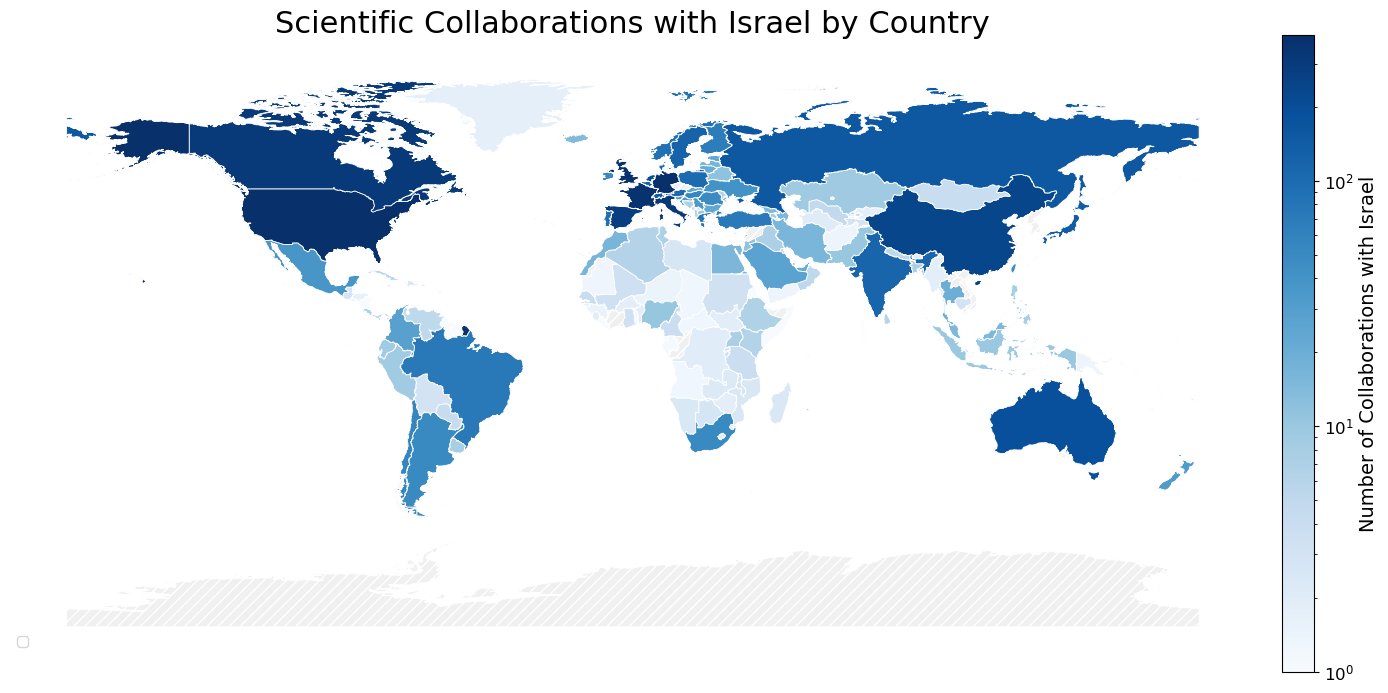

In [10]:
plot_world_choropleth(df_result, value_col="value", title="Scientific Collaborations with Israel by Country", scale='log',cmap_name="Blues")


In [ ]:
import matplotlib.pyplot as plt

# Define decades
decades = [(1950, 1959), (1960, 1969), (1970, 1979),
           (1980, 1989), (1990, 1999), (2000, 2009),
           (2010, 2019), (2020, 2022)]

# Grid size (adjust rows, cols as needed)
fig, axes = plt.subplots(4, 2, figsize=(28, 14))  # 2 rows × 4 columns
axes = axes.flatten()

for ax, (start_year, end_year) in zip(axes, decades):
    subset = df_result[(df_result["year"] >= start_year) & (df_result["year"] <= end_year)]

    # Aggregate decade values (sum collaborations per country)
    subset_decade = subset.groupby("country", as_index=False)["value"].sum()

    plot_world_choropleth(
        subset_decade,
        value_col="value",
        title=f"{start_year}-{end_year}",
        scale="log",
        cmap_name="Blues",
        ax=ax,
        add_colorbar=False   # hide multiple colorbars
    )

# Add one shared colorbar for all maps
sm = cm.ScalarMappable(norm=Normalize(vmin=df_result["value"].min(), vmax=df_result["value"].max()),
                       cmap=cm.get_cmap("Blues"))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, fraction=0.02, pad=0.02)
cbar.ax.set_ylabel("Number of Collaborations with Israel", fontsize=16)

plt.tight_layout()
plt.show()


/tmp/ipykernel_2301585/3259609289.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)
